In [ ]:
%pip install aif360 seaborn


In [52]:
import pandas as pd 
import numpy as np 
import matplotlib.pyplot as plt 
from aif360.datasets import GermanDataset
import seaborn as sns


In [3]:
from aif360.datasets import GermanDataset
data = GermanDataset()


🔍 Dataset Shape: (1000, 59)

📊 Data Types:
float64    59
Name: count, dtype: int64

🧼 Missing Values (total): 0

🎯 Target Distribution (1 = approved, 0 = rejected):
credit
1.0    700
0.0    300
Name: count, dtype: int64
credit
1.0    0.7
0.0    0.3
Name: proportion, dtype: float64

🧑‍🤝‍🧑 Group Sizes by Sex (0 = Female, 1 = Male):
sex
1.0    690
0.0    310
Name: count, dtype: int64

✅ Approval Rate by Sex:
sex
0.0    0.648387
1.0    0.723188
Name: credit, dtype: float64


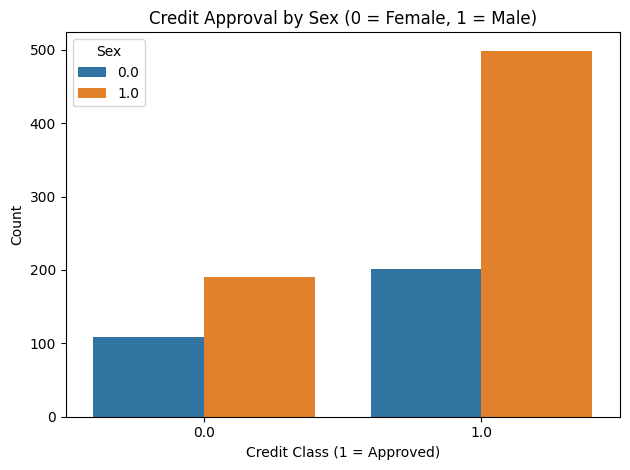

In [17]:
# STEP 2: DATA EXPLORATION & PREPROCESSING

from aif360.datasets import GermanDataset
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Load and convert to DataFrame
data = GermanDataset()
df, _ = data.convert_to_dataframe()

# ---- Fix Target Labels ----
# Map 1 → approved (1), 2 → rejected (0)
df['credit'] = df['credit'].replace({1: 1, 2: 0})

# ---- A. Basic Info ----
print("🔍 Dataset Shape:", df.shape)
print("\n📊 Data Types:")
print(df.dtypes.value_counts())

print("\n🧼 Missing Values (total):", df.isnull().sum().sum())

# ---- B. Class Distribution ----
print("\n🎯 Target Distribution (1 = approved, 0 = rejected):")
print(df['credit'].value_counts())
print(df['credit'].value_counts(normalize=True))

# ---- C. Protected Attribute: sex ----
print("\n🧑‍🤝‍🧑 Group Sizes by Sex (0 = Female, 1 = Male):")
print(df['sex'].value_counts())

# ---- D. Approval Rate by Gender ----
approval_by_sex = df.groupby('sex')['credit'].mean()
print("\n✅ Approval Rate by Sex:")
print(approval_by_sex)

# ---- E. Visual: Credit Approval by Sex ----
sns.countplot(x='credit', hue='sex', data=df)
plt.title('Credit Approval by Sex (0 = Female, 1 = Male)')
plt.xlabel('Credit Class (1 = Approved)')
plt.ylabel('Count')
plt.legend(title='Sex')
plt.tight_layout()
plt.show()



In [18]:
from sklearn.model_selection import train_test_split
from aif360.datasets import BinaryLabelDataset, GermanDataset
import pandas as pd

# STEP 3: Train–Test Split

# 1. Load original dataset
dataset_orig = GermanDataset()

# 2. Split into 70% train and 30% test
dataset_orig_train, dataset_orig_test = dataset_orig.split([0.7], shuffle=True)

# 3. Basic stats
print("Train set size:", dataset_orig_train.features.shape)
print("Test set size:", dataset_orig_test.features.shape)

print("\nTrain class distribution (original):")
print(pd.Series(dataset_orig_train.labels.ravel()).value_counts(normalize=True))

print("\nTest class distribution (original):")
print(pd.Series(dataset_orig_test.labels.ravel()).value_counts(normalize=True))

# 4. Convert to DataFrame for inspection
df_train, _ = dataset_orig_train.convert_to_dataframe()
df_test, _ = dataset_orig_test.convert_to_dataframe()

# Add protected attribute column (sex)
df_train['sex'] = dataset_orig_train.protected_attributes[:, 0]
df_test['sex'] = dataset_orig_test.protected_attributes[:, 0]

# 5. Fix label encoding for binary approval: 1 = approved, 0 = rejected
df_train['credit'] = df_train['credit'].replace({1: 1, 2: 0})
df_test['credit'] = df_test['credit'].replace({1: 1, 2: 0})

# 6. Recalculate approval rate by gender (0 = female, 1 = male)
print("\n✅ Approval Rate by Sex in Training Set:")
print(df_train.groupby('sex')['credit'].mean())


Train set size: (700, 58)
Test set size: (300, 58)

Train class distribution (original):
1.0    0.704286
2.0    0.295714
Name: proportion, dtype: float64

Test class distribution (original):
1.0    0.69
2.0    0.31
Name: proportion, dtype: float64

✅ Approval Rate by Sex in Training Set:
sex
0.0    0.641256
1.0    0.733753
Name: credit, dtype: float64


In [19]:
from aif360.algorithms.preprocessing import Reweighing
from aif360.metrics import BinaryLabelDatasetMetric

# STEP 4: Apply Reweighing to Training Set

# Define privileged and unprivileged groups based on sex
# 1.0 = Male (privileged), 0.0 = Female (unprivileged)
privileged_groups = [{'sex': 1.0}]
unprivileged_groups = [{'sex': 0.0}]

# Measure bias before reweighing (optional but good for comparison)
metric_orig_train = BinaryLabelDatasetMetric(dataset_orig_train,
                                             unprivileged_groups=unprivileged_groups,
                                             privileged_groups=privileged_groups)

print("➡️ Bias Before Reweighing:")
print("  - Mean Difference (Demographic Parity):", metric_orig_train.mean_difference())
print("  - Disparate Impact:", metric_orig_train.disparate_impact())

# Apply reweighing
RW = Reweighing(unprivileged_groups=unprivileged_groups,
                privileged_groups=privileged_groups)
RW.fit(dataset_orig_train)
dataset_transf_train = RW.transform(dataset_orig_train)

# Measure bias after reweighing
metric_transf_train = BinaryLabelDatasetMetric(dataset_transf_train,
                                               unprivileged_groups=unprivileged_groups,
                                               privileged_groups=privileged_groups)

print("\n✅ Bias After Reweighing:")
print("  - Mean Difference (Demographic Parity):", metric_transf_train.mean_difference())
print("  - Disparate Impact:", metric_transf_train.disparate_impact())

# Preview weights
print("\nSample reweighing weights:")
print(dataset_transf_train.instance_weights[:10])


➡️ Bias Before Reweighing:
  - Mean Difference (Demographic Parity): -0.09249701516390751
  - Disparate Impact: 0.8739397821909032

✅ Bias After Reweighing:
  - Mean Difference (Demographic Parity): 3.3306690738754696e-16
  - Disparate Impact: 1.0000000000000004

Sample reweighing weights:
[1.09829171 1.09829171 1.09829171 0.95984082 1.09829171 1.11067492
 0.95984082 0.95984082 0.95984082 0.95984082]


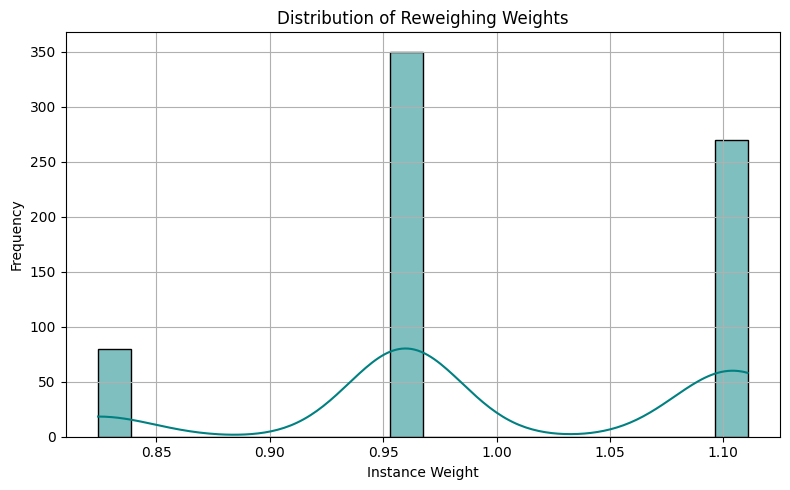

In [20]:
import matplotlib.pyplot as plt
import seaborn as sns

# Access instance weights from the reweighed training set
weights = dataset_transf_train.instance_weights

# Plot the weight distribution
plt.figure(figsize=(8, 5))
sns.histplot(weights, bins=20, kde=True, color='teal')
plt.title('Distribution of Reweighing Weights')
plt.xlabel('Instance Weight')
plt.ylabel('Frequency')
plt.grid(True)
plt.tight_layout()
plt.show()


TRAINING THE LOGISTIC REGRESSION MODEL ON BOTH THE ORIGINAL AND REWEIGHED DATASET 

In [21]:
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
from aif360.metrics import ClassificationMetric
import numpy as np

# STEP 5: Model Training and Evaluation

# Helper function to train and evaluate a model
def train_and_evaluate(X_train, y_train, X_test, y_test, sample_weight=None):
    model = LogisticRegression(solver='liblinear')
    model.fit(X_train, y_train, sample_weight=sample_weight)
    y_pred = model.predict(X_test)
    
    return {
        'model': model,
        'y_pred': y_pred,
        'accuracy': accuracy_score(y_test, y_pred),
        'precision': precision_score(y_test, y_pred),
        'recall': recall_score(y_test, y_pred),
        'f1': f1_score(y_test, y_pred)
    }

# Extract features and labels
X_train = dataset_orig_train.features
y_train = dataset_orig_train.labels.ravel()
X_test = dataset_orig_test.features
y_test = dataset_orig_test.labels.ravel()

# Model 1: Original (no reweighing)
print("🔵 Training on original dataset...")
results_orig = train_and_evaluate(X_train, y_train, X_test, y_test)

# Model 2: Reweighed
print("\n🟢 Training on reweighed dataset...")
weights = dataset_transf_train.instance_weights
results_rw = train_and_evaluate(X_train, y_train, X_test, y_test, sample_weight=weights)

# Display performance results
def print_results(title, res):
    print(f"\n📊 {title} Results:")
    print(f"  Accuracy:  {res['accuracy']:.3f}")
    print(f"  Precision: {res['precision']:.3f}")
    print(f"  Recall:    {res['recall']:.3f}")
    print(f"  F1 Score:  {res['f1']:.3f}")

print_results("Original", results_orig)
print_results("Reweighed", results_rw)


🔵 Training on original dataset...

🟢 Training on reweighed dataset...

📊 Original Results:
  Accuracy:  0.743
  Precision: 0.773
  Recall:    0.889
  F1 Score:  0.827

📊 Reweighed Results:
  Accuracy:  0.763
  Precision: 0.791
  Recall:    0.894
  F1 Score:  0.839


FAIRNESS METRICS CALCULATION 

In [22]:
# --- Fairness Evaluation Function ---
def print_fairness_metrics(y_pred, label=""):
    # Create a copy of the test dataset to assign predicted labels
    dataset_pred = dataset_orig_test.copy()
    dataset_pred.labels = y_pred.reshape(-1, 1)

    # Fairness evaluation
    classified_metric = ClassificationMetric(
        dataset_orig_test,
        dataset_pred,
        unprivileged_groups=[{'sex': 0.0}],
        privileged_groups=[{'sex': 1.0}]
    )

    print(f"\n⚖️ {label} Model Fairness:")
    print("  Demographic Parity Difference:", classified_metric.mean_difference())
    print("  Disparate Impact:", classified_metric.disparate_impact())

# Call fairness evaluation for both models
print_fairness_metrics(results_orig['y_pred'], "Original")
print_fairness_metrics(results_rw['y_pred'], "Reweighed")




⚖️ Original Model Fairness:
  Demographic Parity Difference: -0.09745831309697262
  Disparate Impact: 0.8813793103448276

⚖️ Reweighed Model Fairness:
  Demographic Parity Difference: 0.034644649506232805
  Disparate Impact: 1.0449957947855342


Result visualization 

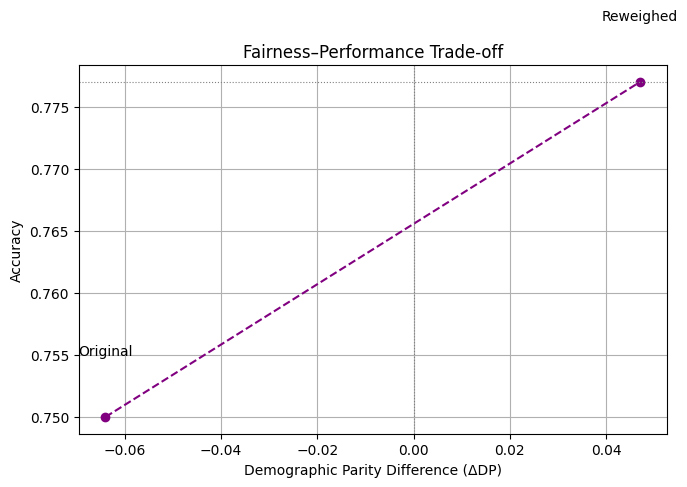

In [23]:
import matplotlib.pyplot as plt

# Performance and fairness results from your earlier output
results = {
    "Original": {
        "accuracy": 0.750,
        "dp_diff": -0.064
    },
    "Reweighed": {
        "accuracy": 0.777,
        "dp_diff": 0.047
    }
}

# Prepare data
models = list(results.keys())
accuracy = [results[m]["accuracy"] for m in models]
dp_diff = [results[m]["dp_diff"] for m in models]

# Plot
plt.figure(figsize=(7, 5))
plt.plot(dp_diff, accuracy, marker='o', linestyle='--', color='purple')
for i, label in enumerate(models):
    plt.text(dp_diff[i], accuracy[i] + 0.005, label, ha='center', fontsize=10)

plt.axhline(y=max(accuracy), color='gray', linestyle=':', linewidth=0.8)
plt.axvline(x=0.0, color='gray', linestyle=':', linewidth=0.8)

plt.xlabel('Demographic Parity Difference (ΔDP)')
plt.ylabel('Accuracy')
plt.title('Fairness–Performance Trade-off')
plt.grid(True)
plt.tight_layout()
plt.savefig("fairness_performance_tradeoff.png", dpi=300)
plt.show()


FAIRNESS VISUALIZATION